<a href="https://colab.research.google.com/github/GabrielaRomoM/SIGNALS-THEORY_2024-1/blob/main/NNModClassificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias

In [ ]:
#librerias
from IPython.display import clear_output
from sklearn.cluster import KMeans
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import pickle
import zipfile
import os

#Keras Tuner
!pip install keras-tuner
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Carga de Base de datos

In [ ]:
def fileload():
  file = '/content/drive/MyDrive/basedata.zip'
  with zipfile.ZipFile(file ,'r') as zip_ref:
    zip_ref.extractall('/content/basedata')

In [ ]:
def read():
  base = '/content/basedata/RML2016.10a_dict.dat'
  try:
    with open(base, 'rb') as f:
      datos = pickle.load(f, encoding='latin1')
      print(datos.keys())
      return datos
  except Exception as e:
    print(f"Error")

#Funciones

## Grafica QPSK, QAM16, QAM64

In [ ]:
def quad(label):
  plt.figure(figsize=(16, 15))
  for i, snr in enumerate(snr_levels[:20]):
      plt.subplot(5, 4, i+1)

      # Signal
      sig = datos['QPSK',snr]
      sig = np.mean(sig, axis=2)

      # Centroids
      centroids = 4
      k_means = KMeans(n_clusters=centroids)
      k_means.fit(sig)
      centroids = k_means.cluster_centers_
      labels = k_means.labels_

      for j in range(centroids.shape[0]):
            plt.scatter(sig[labels == j, 0], sig[labels == j, 1], label=f'Cluster {j}')

      # Plot centroids
      plt.scatter(centroids[:, 0], centroids[:, 1], color='magenta', marker='o', s=100)

      # Graph configuration
      plt.title(f'QPSK')
      plt.xlabel('In-phase')
      plt.ylabel('Quadrature')
      plt.grid(True)

  plt.tight_layout()
  plt.show()

In [ ]:
def qam16(label):
  plt.figure(figsize=(16, 15))
  for i, snr in enumerate(snr_levels[:20]):
      plt.subplot(5, 4, i+1)

      # Signal
      sig = datos['QAM16',snr]
      sig = np.mean(sig, axis=2)

      # Centroids
      centroids = 16
      k_means = KMeans(n_clusters=centroids)
      k_means.fit(sig)
      centroids = k_means.cluster_centers_
      labels = k_means.labels_

      for j in range(centroids.shape[0]):
            plt.scatter(sig[labels == j, 0], sig[labels == j, 1], label=f'Cluster {j}')

      # Plot centroids
      plt.scatter(centroids[:, 0], centroids[:, 1], color='magenta', marker='o', s=100)

      # Graph configuration
      plt.title(f'QAM16')
      plt.xlabel('In-phase')
      plt.ylabel('Quadrature')
      plt.grid(True)

  plt.tight_layout()
  plt.show()

In [ ]:
def qam64(label):
  plt.figure(figsize=(16, 15))
  for i, snr in enumerate(snr_levels[:20]):
      plt.subplot(5, 4, i+1)

      # Signal
      sig = datos['QAM16',snr]
      sig = np.mean(sig, axis=2)

      # Centroids
      centroids = 64
      k_means = KMeans(n_clusters=centroids)
      k_means.fit(sig)
      centroids = k_means.cluster_centers_
      labels = k_means.labels_

      for j in range(centroids.shape[0]):
            plt.scatter(sig[labels == j, 0], sig[labels == j, 1], label=f'Cluster {j}')

      # Plot centroids
      plt.scatter(centroids[:, 0], centroids[:, 1], color='magenta', marker='o', s=25)

      # Graph configuration
      plt.title(f'QMA64')
      plt.xlabel('In-phase')
      plt.ylabel('Quadrature')
      plt.grid(True)

  plt.tight_layout()
  plt.show()

## Guardar como imagenes (Para entrenamiento de red)

In [ ]:
def generateimages(signal_data, snr_levels, label='QAM64'):
    graphs = []

    for i, snr in enumerate(snr_levels[:20]):
        plt.figure(figsize=(4, 2), dpi=100)

        # Signal
        sig = signal_data[label, snr]
        sig = np.mean(sig, axis=2)


        # Determinar la cantidad de centroides según la modulación
        if label == 'QAM64':
            centroids = 64
        elif label == 'QAM16':
            centroids = 16
        elif label == 'QPSK':
            centroids = 4

        # K-means clustering
        k_means = KMeans(n_clusters=centroids)
        k_means.fit(sig)
        labels = k_means.labels_

        # Graficar cada cluster con diferentes colores
        for j in range(centroids):
            plt.scatter(sig[labels == j, 0], sig[labels == j, 1], label=f'Cluster {j}')

        # Mostrar centroides
        plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], color='magenta', marker='o', s=25)

        # Configurar el gráfico
        plt.axis('off')
        plt.tight_layout(pad=0.1)

        # Dibujar el canvas de la figura
        plt.gcf().canvas.draw()

        # Capturar la imagen como un arreglo de píxeles
        graph = np.frombuffer(plt.gcf().canvas.tostring_rgb(), dtype=np.uint8)
        graph = graph.reshape(plt.gcf().canvas.get_width_height()[::-1] + (3,))

        # Ocultar los ejes y espinas
        plt.xticks([])
        plt.yticks([])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)

        # Guardar la imagen en el array
        graphs.append(graph)


    plt.close('all')
    # Retornar el array de imágenes
    return np.array(graphs)

## Etiquetado

In [ ]:
def labelsimg(qpsk_images, qam16_images, qam64_images):
    # Combine all images into a single array
    all_images = np.concatenate([qpsk_images, qam16_images, qam64_images], axis=0)

    # Create corresponding labels
    labels = np.array(['QPSK'] * len(imagesqpsk) + ['QAM16'] * len(imagesqam16) + ['QAM64'] * len(imagesqam64))

    print(f"Total images: {len(all_images)}")
    print(f"Shape of all_images: {all_images.shape}")
    print(f"Shape of labels: {labels.shape}")

    return labels, all_images

## Preparación datos (CNN)

In [ ]:
def prepare_data(labels, all_images):
  # Convert labels to numerical format
  le = LabelEncoder()
  numerical_labels = le.fit_transform(labels)

  # Convert to one-hot encoding
  y = keras.utils.to_categorical(numerical_labels)

  # Normalize image data
  X = all_images.astype('float32') / 255.0

  # Split the data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  return X_train, X_test, y_train, y_test,le

## Construcción Modelo CNN

In [ ]:
def build_model(hp):
    model = keras.Sequential([
        keras.layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            input_shape=(200, 400, 3)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=128, step=32),
            activation='relu'),
        keras.layers.Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
        keras.layers.Dense(3, activation='softmax')  # 3 classes for QPSK, QAM16, QAM64
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Predictions

In [ ]:
def predict_and_visualize(best_model, X_test, y_test, le):
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


    # Visualize some predictions
    n_to_show = min(5, len(X_test))  # Show up to 5 images, or fewer if test set is smaller
    fig, axes = plt.subplots(1, n_to_show, figsize=(20, 4))
    for i in range(n_to_show):
        ax = axes[i] if n_to_show > 1 else axes  # Handle case where there's only one subplot
        ax.imshow(X_test[i])
        true_label = le.inverse_transform([y_true_classes[i]])[0]
        pred_label = le.inverse_transform([y_pred_classes[i]])[0]
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    print()

    # Print true labels vs predictions
    print("\nTrue Labels vs Predictions:")
    for i in range(len(y_true_classes)):
      true_label = le.inverse_transform([y_true_classes[i]])[0]
      pred_label = le.inverse_transform([y_pred_classes[i]])[0]
      print(f"Sample {i+1}: True: {true_label}, Predicted: {pred_label}")

#Ejecución

## Carga de Base de datos

In [ ]:
fileload()
datos = read()
# Extract modulation forms from the dictionary keys
modulation_forms = list({key[0] for key in datos.keys()})
snr_levels = sorted(list({key[1] for key in datos.keys()}))

dict_keys([('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('PAM4', -6), ('WBFM', -18), ('AM-DSB', 16), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('AM-SSB', 6), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('AM-SSB', -12), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('BPSK', -10), ('QPSK', 8), ('PAM4', 14), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('WBFM', -4), ('AM-SSB', -18), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('8PSK', -8), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('AM-SSB', 8), ('GFSK', 18), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('AM-SSB', -2), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('AM-SSB', 2), ('WBFM', 10), ('AM-DSB', -12), ('PAM4

## QPSK, QAM16, QAM64

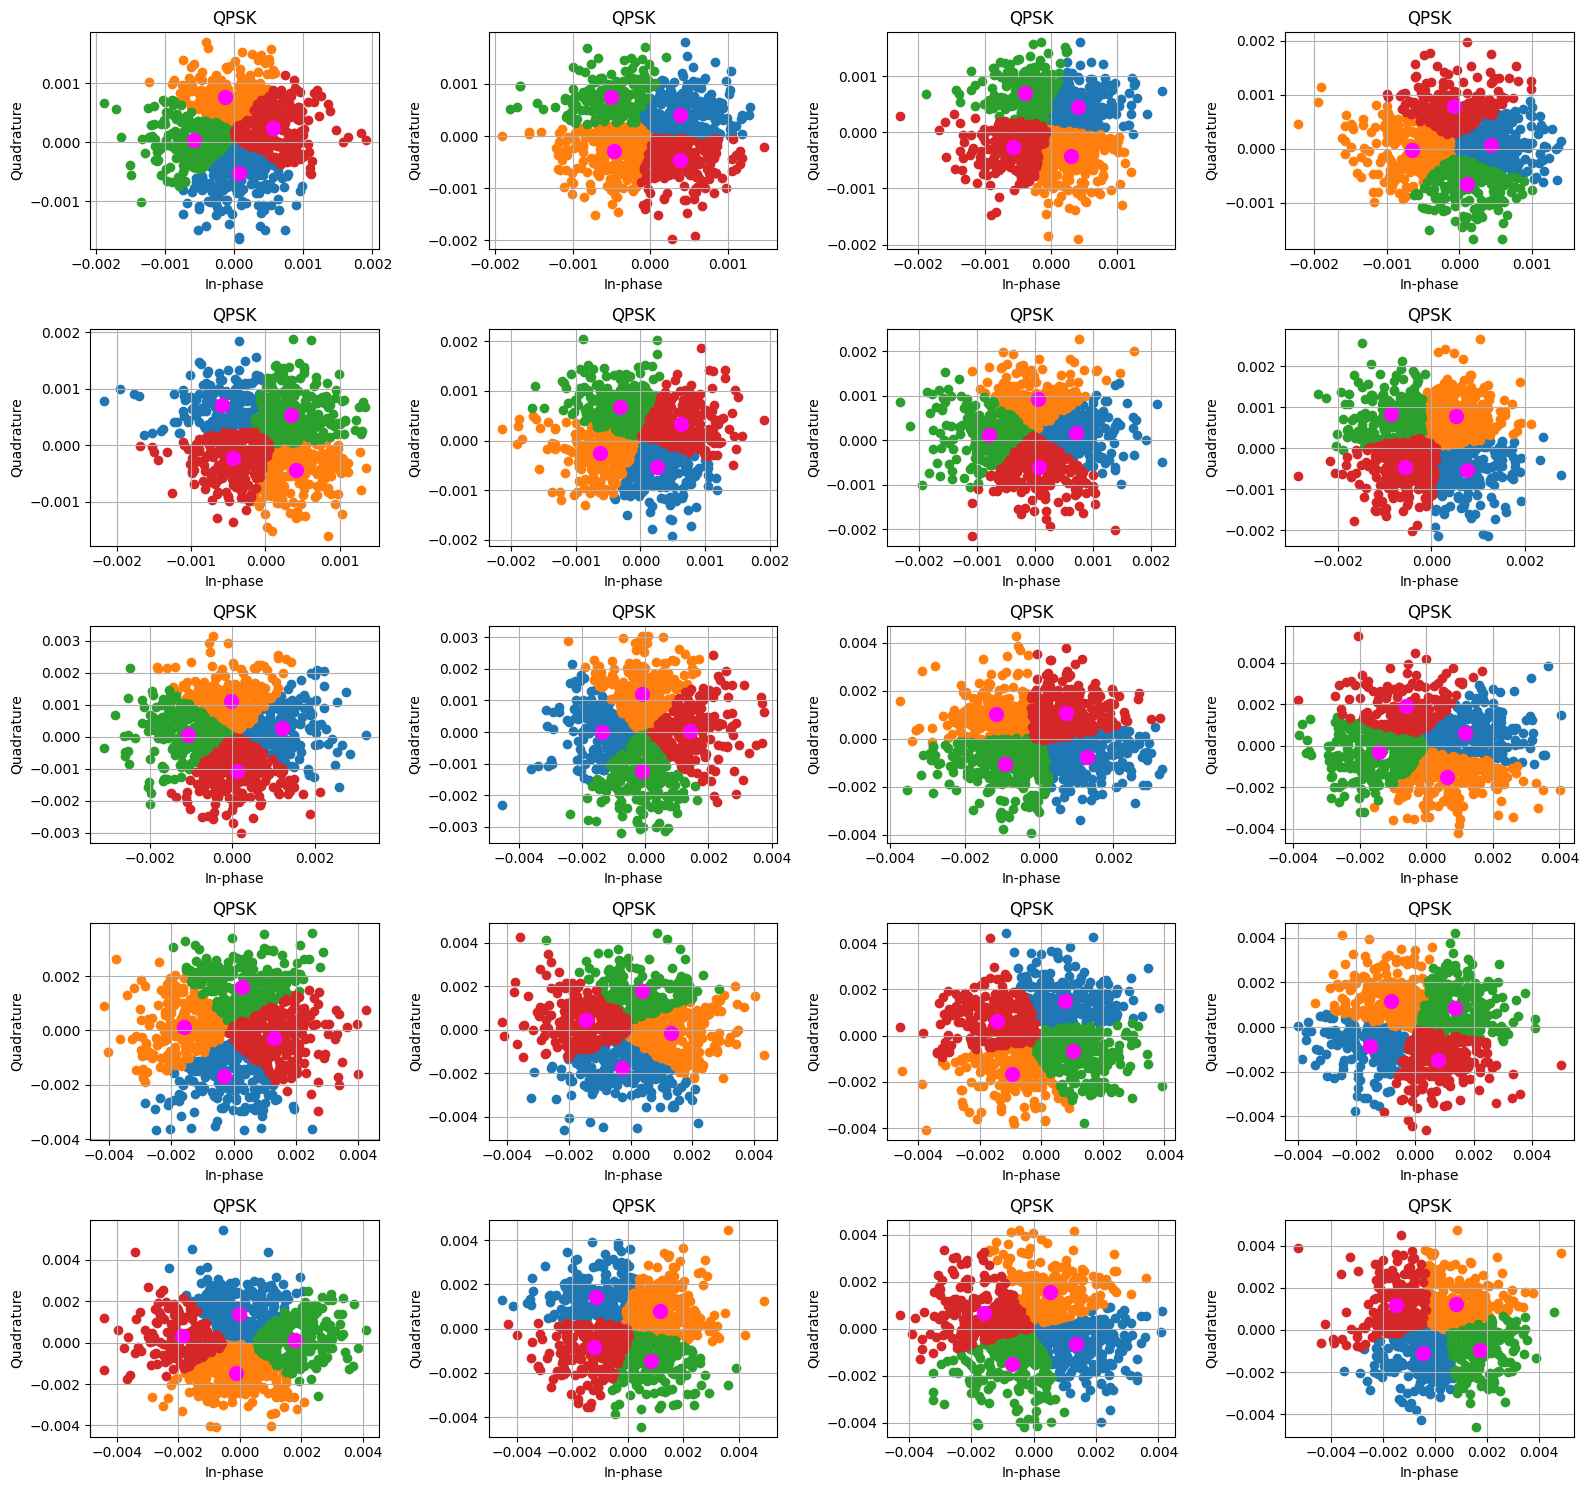

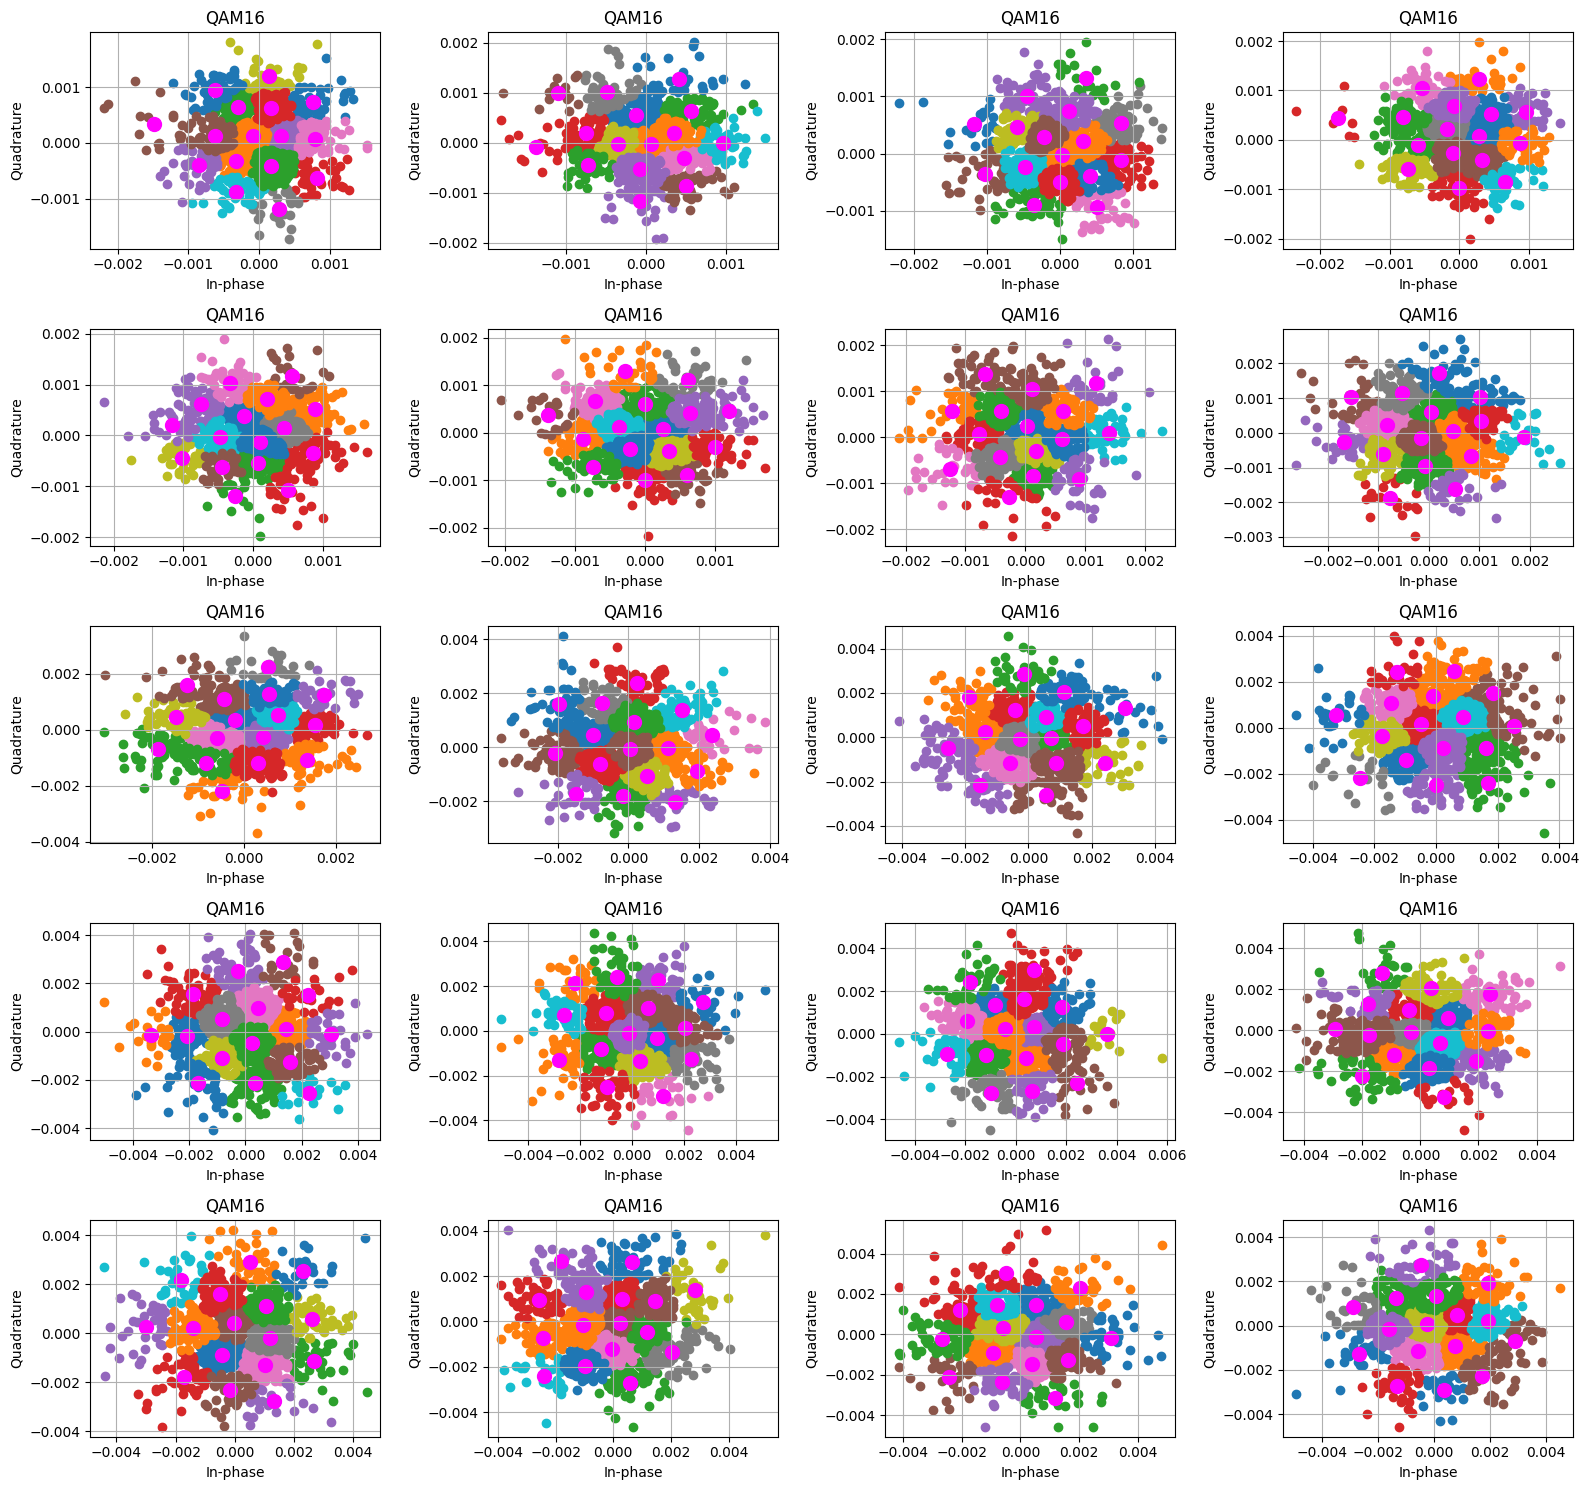

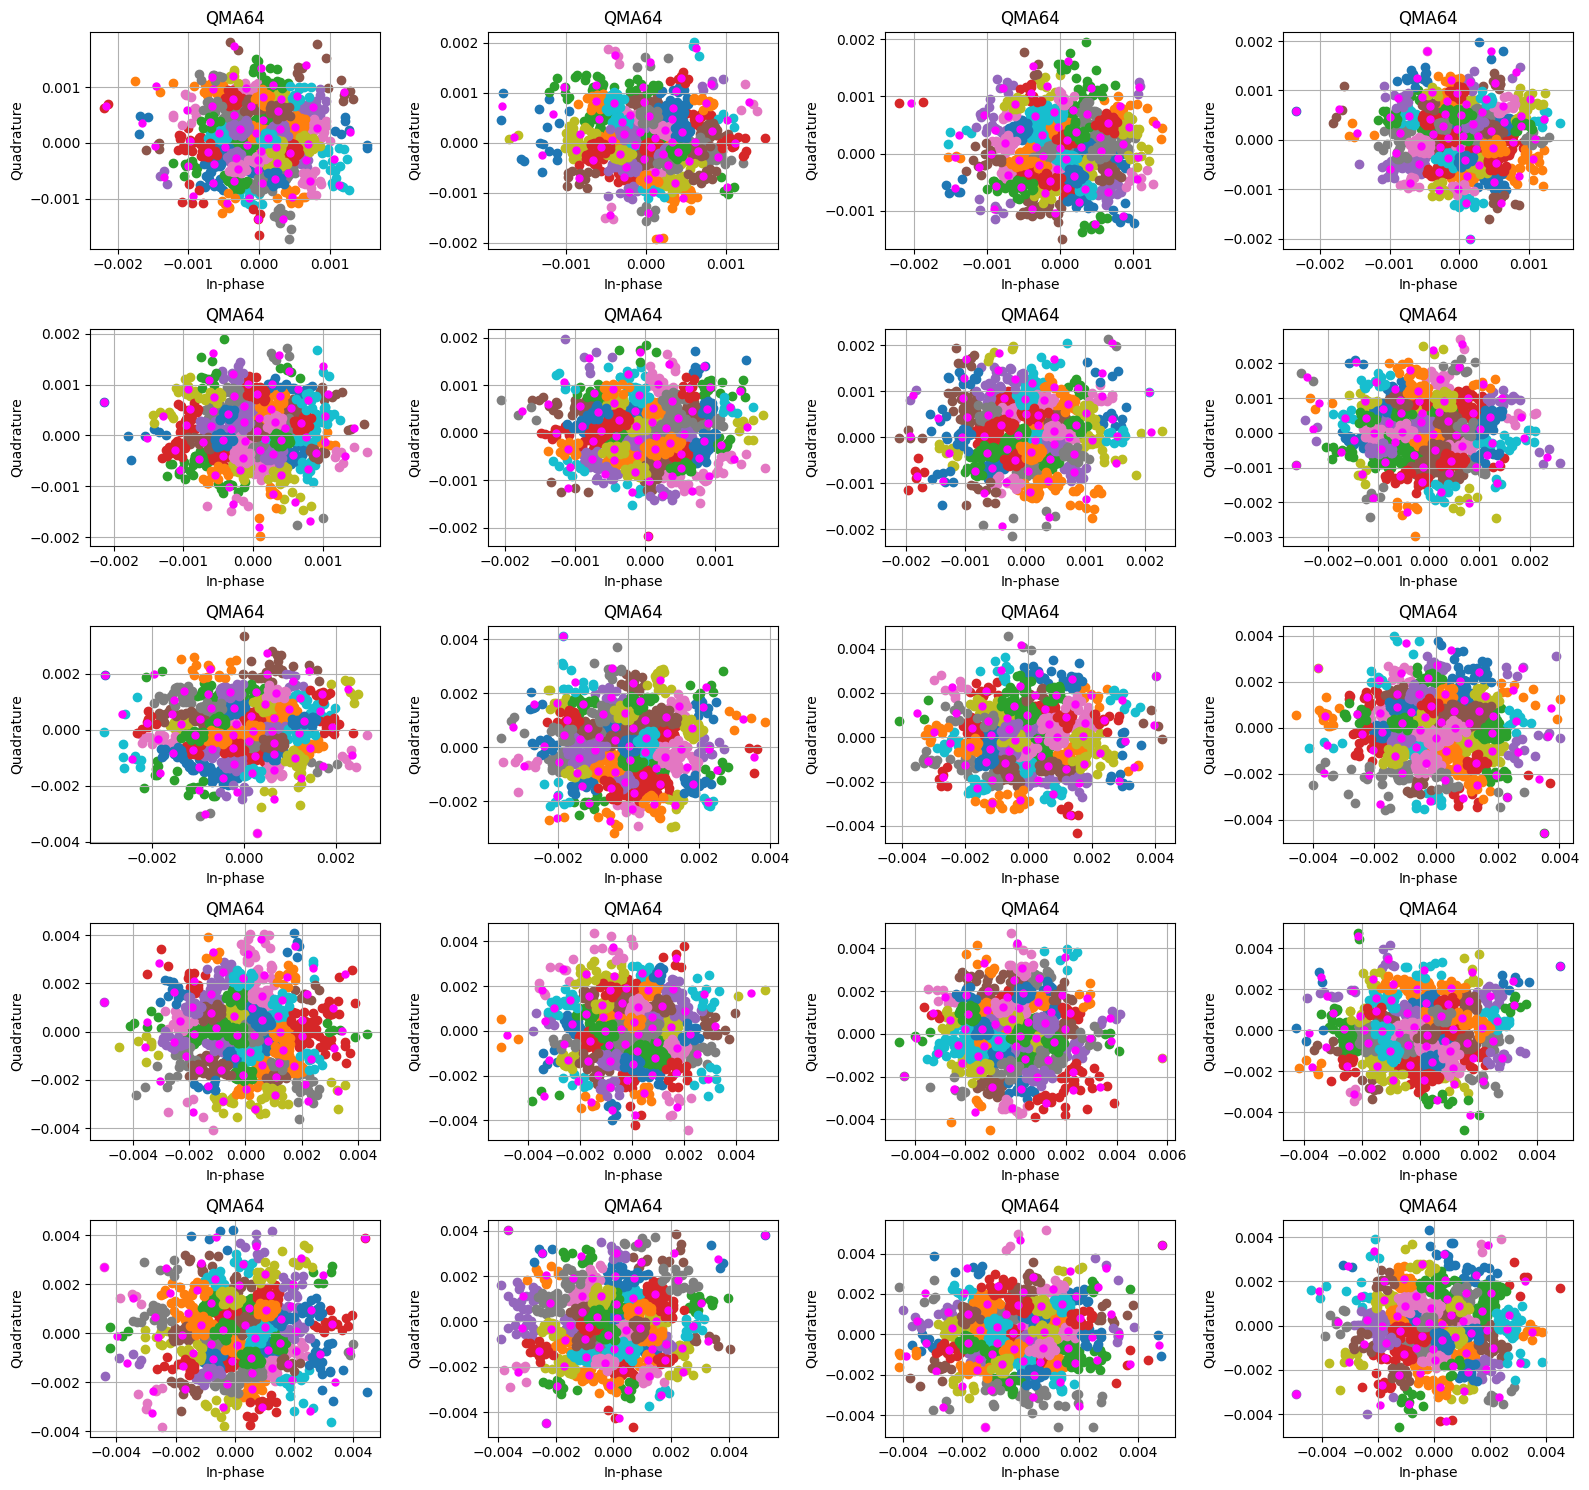

In [ ]:
quad('QPSK')
qam16('QAM16')
qam64("QAM64")

## Guardar como imagenes

In [ ]:
imagesqpsk = generateimages(datos, snr_levels, label='QPSK')
print(f"Total de imágenes generadas: {len(imagesqpsk)}")
imagesqam16 = generateimages(datos, snr_levels, label='QAM16')
print(f"Total de imágenes generadas: {len(imagesqam16)}")
imagesqam64 = generateimages(datos, snr_levels, label='QAM64')
print(f"Total de imágenes generadas: {len(imagesqam64)}")

Total de imágenes generadas: 20
Total de imágenes generadas: 20
Total de imágenes generadas: 20


In [ ]:
print(imagesqpsk.shape)
print(imagesqam16.shape)
print(imagesqam64.shape)

(20, 200, 400, 3)
(20, 200, 400, 3)
(20, 200, 400, 3)


###.

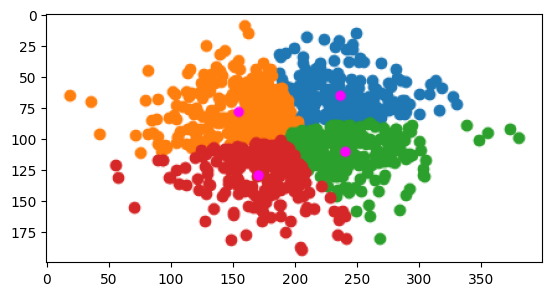

In [ ]:
plt.imshow(imagesqpsk[0])
plt.show()

In [ ]:
labels, all_images = labelsimg(imagesqpsk,imagesqam16,imagesqam64)

Total images: 60
Shape of all_images: (60, 200, 400, 3)
Shape of labels: (60,)


## Entrenamiento modelo

In [ ]:
# Prepara los datos
X_train, X_test, y_train, y_test, le = prepare_data(labels, all_images)

In [ ]:
# Create and run the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Reduced number of trials due to small dataset
    directory='modulation_classification_tuner',
    project_name='modulation_cnn_optimized'
)

# Data augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

# Search for the best hyperparameters
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model with data augmentation
history = best_model.fit(
    data_augmentation(X_train),
    y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=7)
    ]
)

Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.800000011920929
Total elapsed time: 00h 04m 22s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6957 - loss: 0.6896 - val_accuracy: 0.5000 - val_loss: 1.1163 - learning_rate: 3.2632e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7308 - loss: 0.5654 - val_accuracy: 0.6000 - val_loss: 0.6876 - learning_rate: 3.2632e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9825 - loss: 0.2864 - val_accuracy: 1.0000 - val_loss: 0.5058 - learning_rate: 3.2632e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.3165 - val_accuracy: 1.0000 - val_loss: 0.4560 - learning_rate: 3.2632e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.2641 - val_accuracy: 0.7000 - val_loss: 0.5341 - learning_rate: 3.2632e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.1706 - val_accuracy: 0.6000 - val_loss: 0.7214 - learning_rate: 3.2632e-04
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9720 - loss: 0

In [ ]:
# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print()
best_model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9167 - loss: 0.3069
Test accuracy: 0.9167



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 398, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 199, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 95, 195, 32)         │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 47, 97, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 145888)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       4,668,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,085,227 (53.73 MB)

 Trainable params: 4,695,075 (17.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,390,152 (35.82 MB)

In [ ]:
# Guarda el modelo
best_model.save('modulationclassificator.keras')

## Cargar Modelo Entrenado

In [ ]:
from keras.models import load_model

# Load the model from the 'saved_model' directory
best_model = load_model('modulationclassificator.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Classification Report:
              precision    recall  f1-score   support

       QAM16       1.00      0.75      0.86         4
       QAM64       1.00      1.00      1.00         4
        QPSK       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



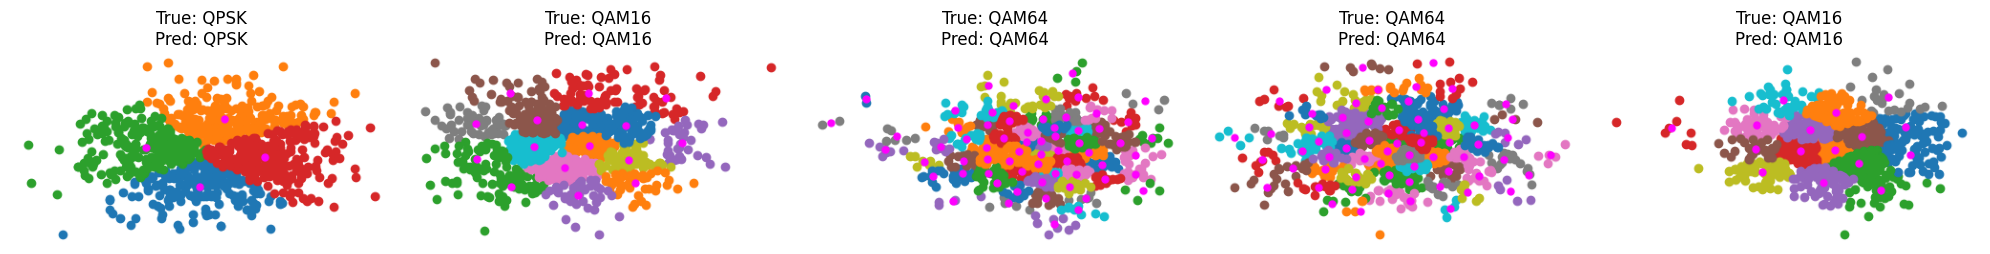



True Labels vs Predictions:
Sample 1: True: QPSK, Predicted: QPSK
Sample 2: True: QAM16, Predicted: QAM16
Sample 3: True: QAM64, Predicted: QAM64
Sample 4: True: QAM64, Predicted: QAM64
Sample 5: True: QAM16, Predicted: QAM16
Sample 6: True: QPSK, Predicted: QPSK
Sample 7: True: QAM16, Predicted: QPSK
Sample 8: True: QPSK, Predicted: QPSK
Sample 9: True: QAM64, Predicted: QAM64
Sample 10: True: QAM64, Predicted: QAM64
Sample 11: True: QAM16, Predicted: QAM16
Sample 12: True: QPSK, Predicted: QPSK


In [ ]:
predict_and_visualize(best_model, X_test, y_test, le)